This is based on the Captum BERT-interpretation demo notebook, adapted for multiple choice models, and hopefully more instructive by indicating clearly the expected tensor shapes for the catum methods. Overall, Captum is neither wonderful nor horrible to work with, but I suspect transformer lens / more specific libraries could make for a more enjoyable coding experience.

The applications listed are suggestions for further research, and none have been completed satisfactorily.

### Application I: Finding Physical Misunderstandings on the FCI of BERT-Style Models Fine-Tuned for Multiple Choice

We use Integrated Gradients from Captum to compute word attributions on the FCI for a BERT-model fine-tuned for answering mulitple choice questions. Specifically, we want to see whether the emphasised words indicate that the model exhibits the same common misconceptions as humans. In the example question below, even if the model gives a common wrong answer (eg. that the pushing car exerts a larger force, or that the heavier object exerts a larger force) we can perhaps use attribution to see precisely which words throw the model off, and then modify the prompt to determine by causal experiments what the model's misconception is. There is detailed qualitative research on student misconceptions on the FCI which could aid us greatly in finding likely misconceptions.

Alas, I cannot compute the gradients for large models with long inputs on my laptop, and our MpC-models are not trained for long physics questions, so the models used here are not sufficiently good to get at all interesting results with these. Therefore, we use a basic test question instead. Still, the code will hopefully be directly applicable to any appropriate model (potentially self fine-tuned for the purpose) with minimal adjustments, and we show as an example how to (very slighlty) modify it for a slighly different architechture (RoBERTa).

---

Example FCI-question: *A large truck breaks down out on the road and receives a push back into town by a small compact car. After the car reaches the constant cruising speed at which its driver wishes to push the truck:*

0) *The amount of force with which the car pushes on the truck is equal to that with which the truck pushes back on the car.*
1) *The amount of force with which the car pushes on the truck is smaller than that with which the truck pushes back on the car.*
2) *The amount of force with which the car pushes on the truck is greater than that with which the truck pushes back on the car.*
3) *The car's engine is running so the car pushes against the truck, but the truck's engine is not running so the truck cannot push back against the car. The truck is pushed forward simply because it is in the way of the car.*
4) *Neither the car nor the truck exert any force on the other. The truck is pushed forward simply because it is in the way of the car.*


In [ ]:
# Test question (replace with some FCI-question)
question = "What is the capital of France?"
choices = ["Berlin", "Madrid", "Paris",] # "Rome", "India"]
ground_truth_idx = 2

In [132]:
# Imports
import torch
from transformers import BertTokenizer, BertForMultipleChoice
from captum.attr import IntegratedGradients, LayerIntegratedGradients, LayerConductance
from captum.attr import visualization as viz
from dataclasses import dataclass

# Settings
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Config (only for debug here)
@dataclass
class Config:
    debug: bool = True
cfg = Config()

In [ ]:
# Load model and tokenizer (replace with a model with some rudimentary physics understanding)
model_name = 'jonastokoliu/multi_choice_bert-base-uncased_swag_finetune' # Pretrained (bad) MpC model
model = BertForMultipleChoice.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()
# model # Uncomment to print architecture

First, we create a custom forward function, taking as arguments

> 1. the preembedded input tokens, 
> 2. the attention masks (since every choice may have a different length, we use padding tokens which should be masked) and
> 3. token type ids (which signify where the question ends and the choice begins), all of shape [num_choices, seq_len], 

and returning
 
> 1. the numbers we want to attribute with respect to (usually the logits). 

For multiple choice, we return a tensor [batch_size, num_choices], and we will specify the index to attribute (that will be the model's predicted index) in the final attribution call to reduce this tensor to a single scalar number. Note that we use the softmaxed output instead of the logits, since we want to know why one choice is *preferred to the others* (with logits, every index could increase simultaneously, so it is not a good choice for differentiating the choices).

Effectively, this is just telling Captum what number we should attribute with respect to, and we will later showcase how one could use this to attempt input attribution for an embedding model.

In [134]:
def forward_func_MpC(inputs_embeds, attention_mask, token_type_ids=None): 
    """Custom forward pass for Captum Integrated Gradients. 
    
    Captum expects a 2D tensor ([batch_size=num_choices, seq_len]),
    while mulitple choice/classification models expect [batch size, num_choices, seq_len],
    so we unsqueeze the first index to add batch_size=1. 
    We return the normalized logits for each choice.
    Some models (eg. RoBERTa) do not use token_type_ids, hence the optional parameter."""

    # Reshaping for multiple choice compatibility
    inputs_embeds = inputs_embeds.unsqueeze(0) # If attributing the embedding layer, this will be different, see below.
    attention_mask = attention_mask.unsqueeze(0)
    if token_type_ids is not None: token_type_ids = token_type_ids.unsqueeze(0)

    logits = model(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    ).logits

    if cfg.debug: print("Logit shape from forward pass:", logits.shape)
    return logits.softmax(dim=-1) # normalizing to differentiate choices


We now create a convenience function for tokenizing and preembedding the inputs (question + choices) and making the model prediction.

In [135]:
# Get input_ids, inputs_embeds, attention_masks, token_type_ids for Captum attribution methods 
# and make model prediciton to get probabilities and choice_idx

def get_encoding_and_predict(question, choices, tokenizer, embed_layer=model.bert.embeddings, type_tokens=True, print_output=True):
    """Tokenizes and preembeds the question and choices and makes prediction, returning input_ids, attention_masks, and token_type_ids, 
    logits and choice index. token_type_ids is None if token_types is False. The input ids are shaped as [num_choices, seq_len]."""
    
    # Tokenize for multiple choice and get input ids, attention masks, and token type ids
    encoding = tokenizer(
        [question] * len(choices),
        choices,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    input_ids = encoding["input_ids"]               # shape: [num_choices, seq_len]
    attention_masks = encoding["attention_mask"]    # -"-
    if type_tokens:
        token_type_ids = encoding["token_type_ids"] # -"-
    else:
        token_type_ids = None

    # Run input_ids through preembed layer
    inputs_embeds = embed_layer(input_ids, token_type_ids=token_type_ids) # position_ids are generated by default

    # Compute model prediction and get choice index
    probs = forward_func_MpC(inputs_embeds, attention_mask=attention_masks, token_type_ids=token_type_ids)
    choice_idx = torch.argmax(probs).item()

    if print_output:
        print('Question:', question)
        print('Predicted Answer:', f'{choice_idx})', choices[choice_idx])
    if cfg.debug: print('Probabilities:', probs) # To gauge model confidence

    # Get baseline with previous function
    return input_ids, inputs_embeds, attention_masks, token_type_ids, probs, choice_idx


# Quick computation
input_ids, inputs_embeds, attention_masks, token_type_ids, probs, choice_idx = get_encoding_and_predict(question, choices, tokenizer)

Logit shape from forward pass: torch.Size([1, 3])
Question: What is the capital of France?
Predicted Answer: 2) Paris
Probabilities: tensor([[0.0797, 0.1972, 0.7231]], grad_fn=<SoftmaxBackward0>)


Integrated Gradients calculates the attribution by differentiation, varying the input between the a baseline and the original input. For MpC, one very natural baseline based on the input ids of the chosen index is generated generally by the following function (the format is indicated in the inline comment).

In [136]:
# Baseline inputs embeds for Integrated Gradients
def get_baseline(tokenizer, input_ids, choice_idx, embed_layer=model.bert.embeddings):
    ref_token_id = tokenizer.pad_token_id   # padding
    sep_token_id = tokenizer.sep_token_id   # sepatator
    cls_token_id = tokenizer.cls_token_id   # start of sequence

    # Create baseline input: [CLS] [PAD] ... [PAD] [SEP] [PAD] ... [PAD] [SEP] [PAD] ... like choice_ids, expanded as input_ids
    ref_tokens = [cls_token_id]
    for token in input_ids[choice_idx, 1:]:
        if token == sep_token_id: # We keep only the separators, else we use padding
            ref_tokens += [sep_token_id]
        else:
            ref_tokens += [ref_token_id]
    
    ref_input_ids = torch.tensor(ref_tokens, dtype=torch.long).expand_as(input_ids)
    ref_token_type_ids = torch.zeros_like(ref_input_ids)

    return embed_layer(ref_input_ids, token_type_ids=ref_token_type_ids) # preembed for multi-layer attribution

ref_inputs_embeds = get_baseline(tokenizer, input_ids, choice_idx)

We now make a convenience function for getting the token attributions, summing over the internal model dimension to get an overal attribution for each position (token).

In [137]:
def get_token_attributions(forward_func, choice_idx, inputs_embeds, ref_inputs_embeds, attention_masks, token_type_ids=None, n_steps=50):

    if cfg.debug: print(inputs_embeds.shape)
    
    # LayerIntegratedGradients for attribution
    ig = IntegratedGradients(forward_func)

    # Compute attributions for chosen index 
    # (Captum wants [num_choices, seq_len] and gives attr shape [choices, seq_len, layer_output_dim])
    attributions, delta = ig.attribute(
        inputs=inputs_embeds,
        baselines=ref_inputs_embeds,
        additional_forward_args=(attention_masks, token_type_ids),
        target=choice_idx,              # Target the chosen answer, takes idx [0,target] of forward_func output
        n_steps=n_steps,                # Number of steps for approximation
        return_convergence_delta=True   # Error estimate
    )
    # Captum attributes every input wrt the target idx. We only care about the choice_idx attributions, 
    # but we have to pass in all the mulitple choice alternatives in order to get the correct softmax output.
    # This significantly increases compute time!

    # Sum across layer_output_dim to get token-level importance¨
    print(attributions.shape)
    choice_token_attributions = attributions[choice_idx].sum(dim=-1)  # shape: [num_choices, seq_len]
    choice_token_attributions = choice_token_attributions / torch.norm(choice_token_attributions)  # Normalize

    if cfg.debug: print('Attributions per token at choice_idx:', choice_token_attributions)
    
    return choice_token_attributions, delta

Here comes the main computation block, which can take several minutes with no GPU depending on the model, input length and number of steps. With our toy example, it should take seconds even on a laptop CPU.

In [140]:
# Main computation block, can take several minutes depending on the model, input length and number of steps.
# If cfg.debug is True, it will print intermediate results to indicate progress.

token_attributions, delta = get_token_attributions(
    forward_func_MpC, choice_idx, inputs_embeds, ref_inputs_embeds, attention_masks, token_type_ids
)

# Convert input_ids to readable tokens for the choice_idx
tokens = tokenizer.convert_ids_to_tokens(input_ids[choice_idx])

torch.Size([3, 11, 768])
Logit shape from forward pass: torch.Size([1, 150])
Logit shape from forward pass: torch.Size([1, 3])
Logit shape from forward pass: torch.Size([1, 3])
torch.Size([3, 11, 768])
Attributions per token at choice_idx: tensor([ 0.0000, -0.2769,  0.0954,  0.0860,  0.1008, -0.2202,  0.2358, -0.6626,
         0.0000,  0.5882, -0.0874], grad_fn=<DivBackward0>)


At last, we use Captum to make a neat visualisation of the attribution.

In [141]:
# Visualise
vis = viz.VisualizationDataRecord(
                        token_attributions,         # word attributions
                        torch.max(probs),           # prediction probability
                        torch.argmax(probs),        # predicted class
                        ground_truth_idx,           # ground truth class
                        str(choice_idx),            # attributing to this class
                        token_attributions.sum(),   # summed attribution score
                        tokens,                     # tokens for the question and choice
                        delta,                      # convergence delta
)

visualisation = viz.visualize_text([vis]) # Save return object to avoid passing the vis object to the ipynb

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.72),2,-0.14,[CLS] what is the capital of france ? [SEP] paris [SEP]


Indeed, the words "France", "capital" and "Paris" seems to be the main positive contributors, though the attribution score is very low. The model credence is also very poor at 65%, so a better model should be used.

#### Adapting for another model

This short section adds nothing new, but collects the above in a convenience function and shows how to apply it to a slightly bigger, and much better, RoBERTa model. The only required modification is that RoBERTa does not use type_token_ids:

In [105]:
# Nothing new here, just importing the RoBERTa model. We use the question and choices from before.
from transformers import RobertaTokenizer, RobertaForMultipleChoice

# Load model and tokenizer
model_name = "LIAMF-USP/roberta-large-finetuned-race"
model = RobertaForMultipleChoice.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()
# model # Uncomment to print architecture

All-in-one convenience wrapper:

In [ ]:
def do_everything(forward_func, layer, question=question, choices=choices, ground_truth_idx=ground_truth_idx, tokenizer=tokenizer, type_tokens=False, n_steps=50):
    """A quick function to do everything we have implemented so far: tokenize, make prediction, compute attributions and visualize."""
    # Tokenize for multiple choice and get input ids, attention masks, WITHOUT token type ids (if token_types=False), 
    # and make prediction to get logits and choice index
    input_ids, inputs_embeds, attention_masks, token_type_ids, probs, choice_idx = get_encoding_and_predict(question, choices, tokenizer, layer, type_tokens=type_tokens)
    ref_inputs_embeds = get_baseline(tokenizer, input_ids, choice_idx, layer)

    # Compute attributition at choice idx
    token_attributions, delta = get_token_attributions(
        forward_func, choice_idx, inputs_embeds, ref_inputs_embeds, attention_masks, token_type_ids, n_steps=n_steps, 
    )

    # Visualize
    tokens = tokenizer.convert_ids_to_tokens(input_ids[choice_idx])

    vis = viz.VisualizationDataRecord(
                        token_attributions,         # word attributions
                        torch.max(probs),           # prediction probability
                        torch.argmax(probs),        # predicted class
                        ground_truth_idx,           # ground truth class
                        str(choice_idx),            # attributing to this class
                        token_attributions.sum(),   # summed attribution score
                        tokens,                     # tokens for the question and choice
                        delta,                      # convergence delta
    )

    viz.visualize_text([vis])

    return choice_idx

Main computation block, which could take several minutes on a laptop CPU.

In [107]:
# Compute attributions for RoBERTa
layer = model.roberta.embeddings
do_everything(forward_func_MpC, layer)

Logit shape from forward pass: torch.Size([1, 5])
Question: What is the capital of France?
Predicted Answer: 2) Paris
Probabilities: tensor([[1.0868e-02, 1.9246e-03, 9.8029e-01, 6.7416e-03, 1.7915e-04]],
       grad_fn=<SoftmaxBackward0>)
torch.Size([5, 13, 1024])
Logit shape from forward pass: torch.Size([1, 250])
Logit shape from forward pass: torch.Size([1, 5])
Logit shape from forward pass: torch.Size([1, 5])
Attributions per token at choice_idx: tensor([ 0.0000, -0.3038,  0.1999,  0.0105, -0.0012, -0.0873,  0.2603,  0.6403,
        -0.1718, -0.2130, -0.4560,  0.3154,  0.0000], grad_fn=<DivBackward0>)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.98),2,0.19,#s What Ġis Ġthe Ġcapital Ġof ĠFrance ? #/s #/s Paris #/s #pad


2

Notice that the model credence is way better, at over 98%, than the previous model. Alas, it is still not great on the FCI, and preliminary testing indicates that it does not really make sense to talk about misconceptions here since the credences are so low (that is, the answers are almost random; I am not convinced that this model has developed any internal understanding of physics). This is not surprising, since the FCI questions are very different from the training data, and since the model is so small as to run on a laptop CPU.

**Note:** The results do not really make sense, as I get negative attr scores with bert. This indicates that the baseline is more likely than the correct result; either my BERT is really very bad, or something is off. With the Roberta, another strange thing ocurs; paris gives a negative contribution, instead the separator contributes. Look it over later.

### Attribution for embedding models

To determine which words in a text chunk are most important for the placement of that chunk in embedding space, we must fist choose a metric on the embedding space and some reference vector. Concretely, we do the following:

> Given a text chunk, we run it thorugh the model to get the corresponding embedding vector. Then, we want to see which words in the chunk we should tune to get the largest change in embedding position; that is, we attribute with respect to the cosine similarity between the true output and the perturbed output.

Ideally, one might want to use a separate vector as a reference, but there is no canonical choice. If the dataset gives a natural clustering, such as in a a MpC/QA-dataset, one could experiment with using the question as the reference vector. 

The following code gives the general procedure, but I am not sure how to test whether it is a sensible/useful approach. This is a particular example of how embedding models may cause difficulty in interpretability, since the output is non-interpretable. There are also other potential issues: i) In high dimensional spaces, most randomly chosen vectors are essentially orthogonal, so unless the perturbations are very small, we might just get orthogonality for all our perturbations, giving basically no information at all. ii) If the linearity hypothesis is not entirely true, the model may weight different directions in embedding space differently, so that a small change along an axis which is very densely populated with different semantic concepts could be more meaningful than a large movement in a sparse direction. I have not investigated either issue at all, as I suspect they will be model and input specific, and I do not have a particular application in mind here.

In [142]:
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer # note that the class structures of Autos are slightly different

# Load model and tokenizer
model_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1" # embedding model
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()
# model # Uncomment to print architecture

In [ ]:
# Mean Pooling - from sentence transformers,
# essentially averaging over all positions to get the actual singe embedding for the whole chunk
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Use preembedded
def embed_tokens(input_ids, attention_mask=None): # Uses global model
    model_output = model(input_ids, attention_mask) # attn mask only needed for padding tokens on acausal models, and we have a single batch
    # Perform pooling and normalize
    embedding = mean_pooling(model_output, attention_mask)
    return F.normalize(embedding, p=2, dim=1)

In [ ]:
# Compute baseline embedding
text = ['This is a test sentence.']
target_idx = 0 # only one input
encoding = tokenizer(text, padding=True, truncation=True, return_tensors='pt') # Tokenize

# Model input
input_ids = encoding['input_ids'] # Get input ids, shape: [batch_size, seq_len]
attention_masks = encoding['attention_mask'] # Get attention masks (for each batch, same shape as input_ids)
inputs_embeds = 

# Baseline embedding for IG
baseline_token_id = tokenizer.pad_token_id 
baseline_ids = torch.full_like(input_ids, baseline_token_id)

# Reference embedding for distance computation
reference_embeddings = embed_tokens(input_ids, attention_masks) # shape: [batch_size, embedding_dim]

if cfg.debug: print(input_ids.shape, attention_masks.shape, baseline_ids.shape, reference_embeddings.shape, ) # Debug shapes

torch.Size([1, 8]) torch.Size([1, 8]) torch.Size([1, 8]) torch.Size([1, 384])


In [145]:
def forward_func_cos_sim(input_ids, attention_mask=None, reference_embeddings=reference_embeddings):
    """Custom forward pass for Captum Integrated Gradients for cosine similarity to reference embeddings."""
    
    embeddings = embed_tokens(input_ids, attention_mask)
    sim = F.cosine_similarity(reference_embeddings, embeddings, dim=1) # Compute cosine distance with baseline embedding

    if cfg.debug: print("Similarity:", sim.shape)
    return sim # tensor of shape [batch_size]

In [ ]:
# Compute model prediction
start_dist = forward_func_cos_sim(input_ids, attention_masks, reference_embeddings)
print("Original distance:", start_dist.item()) # Print original distance

layer = model.embeddings # Get the embedding layer
# get preembeds

ig = IntegratedGradients(forward_func_cos_sim)

# Compute attributions for chosen index (Captum wants [choices, seq_len] and gives attr shape [choices, seq_len, embedding_dim])
attributions, delta = ig.attribute(
    inputs=input_ids,
    baselines=baseline_ids,
    additional_forward_args=(attention_masks, reference_embeddings, ), 
    n_steps=50,  # Number of steps for approximation
    return_convergence_delta=True
)

Similarity: torch.Size([1])
Original distance: 1.0


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [ ]:
# Get word tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[target_idx])

# Step 2: Aggregate attribution scores (across embedding dimension)
# Shape of attributions: [1, seq_len, emb_dim]
token_attributions = attributions.sum(dim=-1).squeeze(0)  # shape: [seq_len]

# Step 3: Print token + attribution
print("Token-wise attributions:")
for token, score in zip(tokens, token_attributions):
    print(f"{token:>12} : {score.item():.4f}")


vis = viz.VisualizationDataRecord(
                        token_attributions,        # token-wise attributions
                        0, # prediction probability (not relevant for distance attribution)
                        0, # predicted class            -"-
                        0, # ground truth class         -"-
                        0, # attributing to this class  -"-
                        token_attributions.sum(),  # summed attribution score (NA)
                        tokens,                    # tokens for the question and choice
                        delta,                     # convergence delta
)

visualisation = viz.visualize_text([vis]) # get return object to avoid passing the vis object to the ipynb

### Layer-wise attribution

Often, we may want to use input attribution to get a rough idea of where a feature may be located in a model. For instance, the fact that Paris is the capitol of France may be stored in some MLP-layer of the model. Once the layer is identified, the specific neurons may ideally be localized with intervention methods (see part 1). This section makes an attempt at implementing such a rough fact-layer search on an encoder for multiple choice, though the results are not great.

In [83]:
#____________

Note the negative overall attribution score; this indicates that the initial embedding layer did not prefer Paris to the other capitals, and that only later layers corrected for this. That aligns with the general view that facts are mostly contained in MLP-layers. In this way we can try to use LIG to indicate what layer has stored the fact "Paris is the capital of France" (alas, there are 24 (!) layers in this model, so we can only do this for a toy model - even here, all layers will by random chance prefer some alternative, so without tracing the full information path thorough the model it is nontrivial to do this in practice). 

The naive approach to find the imporant MLP-layers is given below (not nearly enough steps to get very accurate attributions; the delta-s should be examined if making a through analysis). We see that certain layers (Mainly MLP output-layer 0) give a strong push towards the correct answer, while the later layers are hardly involved or pushes in the opposite direction, and one could try to find a Paris node/feature in the eary layers of the model with patching.

However, there is a much better way to do this with LayerConductance in Captum, which will follow below.

<details>
  <summary> Obvious application [click to expand]  </summary>

Take a toy BERT model which can answer very easy MpCs (like capitals, or easier) and find the "Paris in France" **layer**, then use patching from Frederik to find specific **nodes**. I will not pursue this unless I have time in the end, since it is a straightforward (though not very likely to be successful) application of the tools in this notebook and the patching-notebook.

</details>

In [62]:
# for i in range(len(model.roberta.encoder.layer)):
#     print(i)
#     layer = model.roberta.encoder.layer[i].output # or should i use the hidden mlp layer .intermediate? Can use .dense to do pre-(layerNorm/activation)
#     do_everything(forward_func_softmax, layer, n_steps=5)

### Muli-layer attribution
As a final step with IG-attribution from captum, let's look at how to attribute the whole model rather than only a layer. The only difference is that we provide embeddings instead of ids to the IG attribution method (which is also an option with LIG, but ids are easier), since the ids are discrete/not diffable. So we need to tokenize *and* word/position/type-embed before inputting, and get the attribution for the layers that are not the embedding layers (which are essentially look-up-tables anyway/not the most interesting part of a transformer).

This is really the most interesting for the application described above, while the layer attribution is most useful for coarse feature search before intervening on specific nodes in that layer.

In [104]:

# From here on down, I have not been too careful / reviewed yet - there might be errors (but the code runs).

from captum.attr import LayerConductance

# For plotting heatmaps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Returning to smaller BERT-model
model_name = 'jonastokoliu/multi_choice_bert-base-uncased_swag_finetune' # Pretrained (bad) MpC model
model = BertForMultipleChoice.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()

# Absurd way to get choice idx for testing only
# layer = model.bert.embeddings
# choice_idx = do_everything(forward_func_softmax, layer, model=model, tokenizer=tokenizer, token_types=True)

# Forward func taking embeds
def forward_func_softmax_embed(input_emb, attention_mask=None):
    
    input_emb = input_emb.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    logits = model(
        inputs_embeds=input_emb,
        attention_mask=attention_mask,
    ).logits

    if cfg.debug: print("Logits from forward pass:", logits.shape)
    return logits.softmax(dim=1)

# From demo, to get input_embs and ref_input_embs (running ids through emb layer)
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

In [ ]:
# setup

ref_token_type_ids = torch.zeros_like(token_type_ids)  # Reference token type ids, all zeros for BERT
position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=device)  # Position ids for the input sequence
ref_position_ids = torch.zeros_like(position_ids)  # Reference position ids, all zeros for BERT

input_embs, ref_input_embs = construct_whole_bert_embeddings(
    input_ids, ref_input_ids, token_type_ids=token_type_ids, 
    ref_token_type_ids=ref_token_type_ids, position_ids=position_ids, ref_position_ids=ref_position_ids
) # maybe zero vector is better baseline?

if cfg.debug: print(input_embs.shape, ref_input_embs.shape)

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

torch.Size([3, 11, 768]) torch.Size([3, 11, 768])


In [ ]:
from captum.attr import IntegratedGradients # Not tested yet

# IntegratedGradients
def get_token_attributions_for_model(layer, forward_func, choice_idx, input_embs, ref_input_embs, attention_mask, token_type_ids=None, n_steps=50):

    if cfg.debug: print(input_embs.shape)
    
    # LayerIntegratedGradients for attribution
    ig = IntegratedGradients(forward_func)

    # Compute attributions for chosen index (Captum wants [choices, seq_len] and gives attr shape [choices, seq_len, layer_output_dim])
    attributions, delta = ig.attribute(
        inputs=input_embs,
        baselines=ref_input_embs,
        additional_forward_args=(attention_mask, token_type_ids),
        target=choice_idx,  # Target the chosen answer, uses [0,target]
        n_steps=n_steps,  # Number of steps for approximation
        return_convergence_delta=True
    )

    # Sum across embedding dimensions to get token-level importance
    token_attributions = attributions.sum(dim=-1).squeeze(0)  # shape: [num_choices, seq_len]
    token_attributions = token_attributions / torch.norm(token_attributions)  # Normalize

    if cfg.debug: 
        print('Token attributions:', token_attributions.shape)
        print('Attributions per token at choice_idx:', token_attributions[choice_idx])
    
    return token_attributions, delta


We can also do LayerConductance to see attr-scores for each token across layers - this is for locating the feature to a layer.

In [109]:
layer_attrs = [] # Empty list to store attributions for each layer

for i in range(model.config.num_hidden_layers): # attrubuting tokenwise for each layer
    lc = LayerConductance(forward_func_softmax_embed, model.bert.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=input_embs, baselines=ref_input_embs, additional_forward_args=(attention_masks,), \
                                      target=choice_idx, n_steps=50, ) # reduced steps to speed up, sacrificing acc, though the trend holds up
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())
    print(f"Layer {i+1}:", np.sum(layer_attrs[i][choice_idx]))

Logits from forward pass: torch.Size([1, 153])
Layer 1: -1.2461051386781037
Logits from forward pass: torch.Size([1, 153])
Layer 2: -1.2421367736533284
Logits from forward pass: torch.Size([1, 153])
Layer 3: -1.315762855578214
Logits from forward pass: torch.Size([1, 153])
Layer 4: -1.0917498202761635
Logits from forward pass: torch.Size([1, 153])
Layer 5: -1.1474649207666516
Logits from forward pass: torch.Size([1, 153])
Layer 6: -1.0865842448547482
Logits from forward pass: torch.Size([1, 153])
Layer 7: -1.0264790678629652
Logits from forward pass: torch.Size([1, 153])
Layer 8: -1.032434618100524
Logits from forward pass: torch.Size([1, 153])
Layer 9: -1.0169967371039093
Logits from forward pass: torch.Size([1, 153])
Layer 10: -1.081912085879594
Logits from forward pass: torch.Size([1, 153])
Layer 11: -1.2508521545678377
Logits from forward pass: torch.Size([1, 153])
Layer 12: -0.9224346876144409


These results make no sense, crap. In fact, they seem to be inverted by the plot below...

(12, 3, 11)


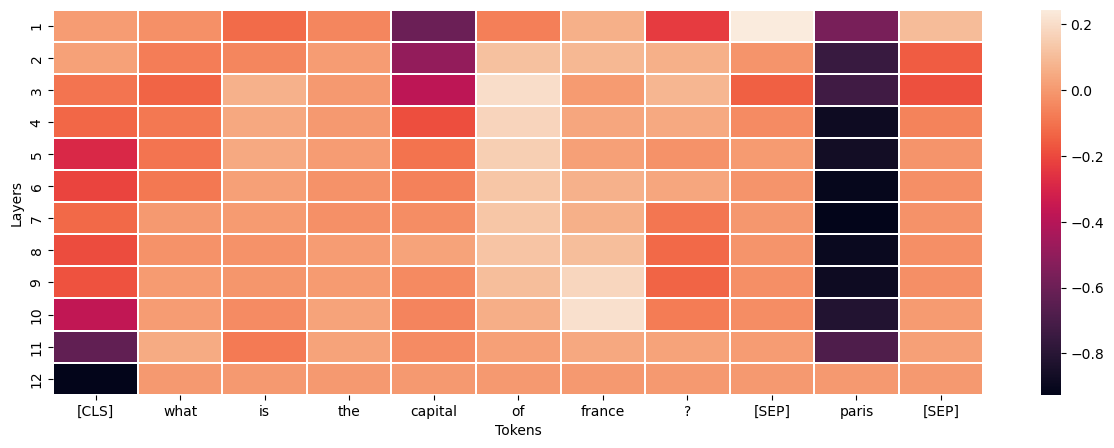

In [110]:
if cfg.debug: print(np.array(layer_attrs).shape)

# Plotting
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=tokenizer.convert_ids_to_tokens(input_ids[choice_idx])
yticklabels=list(range(1, model.config.num_hidden_layers+1))
ax = sns.heatmap(np.array(layer_attrs)[:,choice_idx,:], xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

It is also possible to look closely at specific tokens and how they are processed by each layer, see the very end of the [first Captum BERT demo](https://captum.ai/tutorials/Bert_SQUAD_Interpret) (This should be pretty much similar for our case when treating only the choice idx and using only one attribution rather than start and end). Attn interp can be seen in the attention notebook.